#Trabajo Practico 4

Pinto, Nicolas \\
Padron: 105064

La tarea consiste en construir un clasificador que dada una imagen devuelva la categoría a la que corresponde. ¿Qué tan bien funciona la validación?

##Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from matplotlib import pyplot
from PIL import Image
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
import keras
from keras.models import Sequential

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

import os
import os.path

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Datasets

In [ ]:
!unzip gdrive/My\ Drive/Datasets\ TP4/silkroad2_images.zip  > /dev/null

In [ ]:
silkroad_items = pd.read_csv('gdrive/My Drive/Datasets TP4/silkroad2_csvs.zip (Unzipped Files)/silkroad_items.csv')

In [ ]:
image_folder = '/content/images_by_id/'

##Preparo el dataset

In [ ]:
dictionary = {}
for photo in os.listdir(image_folder):         
  image_path= os.path.join(image_folder, photo)         
  image= Image.open(image_path) 
  image = np.asarray(Image.open(image_path), dtype='uint8')
  if image.shape == (135, 180, 3):
    name = float(photo.replace(".jpg", ""))
    dictionary[name] = image
  del(image)

In [ ]:
filtered_by_id = silkroad_items.loc[silkroad_items['image_id'].isin(dictionary), :].copy()
filtered_images = filtered_by_id[['category','image_id']].copy()
del(filtered_by_id)

Las fotos de alcohol no corresponden a esa categoria y las de other tambien las saque porque quiero calificar cosas en concreto

In [ ]:
filtered_images = filtered_images[filtered_images['category'] != "Alcohol"].copy()
filtered_images = filtered_images[filtered_images['category'] != "Other"].copy()

In [ ]:
categories_frecuency = filtered_images['category'].value_counts()
top_frecuency = categories_frecuency.head(6)
df_frecuency = pd.DataFrame(top_frecuency)
df_frecuency.reset_index(inplace = True)

In [ ]:
top_frecuency = df_frecuency['index'].to_list()

In [ ]:
final_df = filtered_images.loc[(filtered_images['category'].isin(top_frecuency)) ,:].copy()

In [ ]:
final_df = final_df.sample(frac = 1, random_state = 2)

##Divido el dataset

In [ ]:
train_len = int((final_df.shape[0])*0.95)
test_len = int((final_df.shape[0])-train_len)

In [ ]:
train_set = final_df.head(train_len).copy()
test_set = final_df.tail(test_len).copy()

In [ ]:
test_set.drop_duplicates(inplace= True)
train_set.drop_duplicates(inplace=True)

In [ ]:
train_set.shape

(11322, 2)

In [ ]:
test_set.shape

(3226, 2)

In [ ]:
del(top_frecuency)

In [ ]:
del(silkroad_items)

##Encoding

In [ ]:
train_set['image_values'] = train_set['image_id'].map(dictionary)
train_set

,category,image_id,image_values
192459,Weed,27160.0,"[[[252, 253, 255], [252, 253, 255], [252, 253,..."
375116,Ecstasy,42878.0,"[[[123, 139, 112], [110, 126, 100], [99, 113, ..."
332196,MDMA,19473.0,"[[[140, 127, 111], [141, 127, 114], [138, 125,..."
391888,Ecstasy,46178.0,"[[[201, 199, 210], [201, 199, 210], [200, 200,..."
318530,Weed,23067.0,"[[[59, 61, 60], [57, 59, 58], [62, 66, 65], [7..."
...,...,...,...
234945,Cannabis,48126.0,"[[[158, 157, 137], [157, 156, 136], [157, 156,..."
18018,Stimulants,19458.0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
374624,Cannabis,52513.0,"[[[197, 189, 187], [197, 189, 187], [198, 190,..."
58005,Cannabis,27858.0,"[[[51, 39, 27], [51, 39, 27], [51, 39, 27], [5..."


In [ ]:
test_set['image_values'] = test_set['image_id'].map(dictionary)
test_set

,category,image_id,image_values
122128,MDMA,36832.0,"[[[242, 203, 164], [245, 206, 167], [247, 207,..."
369375,Cocaine,38596.0,"[[[18, 19, 14], [18, 19, 14], [18, 19, 14], [1..."
319739,Stimulants,51169.0,"[[[43, 102, 74], [50, 107, 72], [50, 107, 66],..."
233357,Cannabis,45858.0,"[[[194, 180, 169], [197, 183, 172], [200, 186,..."
112978,Weed,23647.0,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."
...,...,...,...
153485,Weed,8504.0,"[[[83, 82, 61], [84, 83, 62], [80, 77, 58], [7..."
212103,MDMA,45028.0,"[[[184, 189, 227], [186, 192, 228], [186, 192,..."
158453,Weed,19188.0,"[[[241, 244, 233], [251, 254, 245], [245, 250,..."
355993,Ecstasy,45041.0,"[[[131, 128, 97], [163, 158, 126], [200, 192, ..."


In [ ]:
del(dictionary)

In [ ]:
column_one_hot = []
column_one_hot.append('category')

In [ ]:
onehotencoder = OneHotEncoder()
y_train = onehotencoder.fit_transform(train_set['category'].values.reshape(-1,1)).toarray()

In [ ]:
y_test = onehotencoder.fit_transform(test_set['category'].values.reshape(-1,1)).toarray()
y_test

array([[0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [ ]:
x_train = train_set['image_values'].tolist()

In [ ]:
x_train = np.array(x_train)

In [ ]:
x_train.shape

(11322, 135, 180, 3)

In [ ]:
y_train.shape

(11322, 6)

In [ ]:
x_test = test_set['image_values'].tolist()
x_test = np.array(x_test)
x_test.shape

(3226, 135, 180, 3)

In [ ]:
y_test.shape

(3226, 6)

In [ ]:
del(final_df)

##Baseline

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
data = x_train.reshape((x_train.shape[0], 72900))
x_test_data = x_test.reshape((x_test.shape[0], 72900))

In [ ]:
model = KNeighborsClassifier()
model.fit(data, y_train)

KNeighborsClassifier()

In [ ]:
ypred_knn= model.predict(x_test_data)
preds_knn = np.argmax(ypred_knn, axis=1)
preds_knn

array([3, 1, 4, ..., 5, 2, 4])

In [ ]:
y_test_arg = np.argmax(y_test, axis=1)
y_test_arg

array([3, 1, 4, ..., 5, 2, 2])

In [ ]:
accuracy_score(y_test_arg, preds_knn)

0.8161810291382517

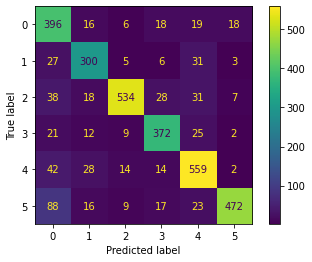

In [ ]:
matrix = confusion_matrix(y_test_arg, preds_knn)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()

In [ ]:
print(classification_report(y_test_arg, preds_knn))

              precision    recall  f1-score   support

           0       0.65      0.84      0.73       473
           1       0.77      0.81      0.79       372
           2       0.93      0.81      0.87       656
           3       0.82      0.84      0.83       441
           4       0.81      0.85      0.83       659
           5       0.94      0.76      0.84       625

    accuracy                           0.82      3226
   macro avg       0.82      0.82      0.81      3226
weighted avg       0.83      0.82      0.82      3226



In [ ]:
output = { 0:'Cannabis',1:'Cocaine',2:'Ecstasy',3:'MDMA',4:'Stimulants',5:'Weed'}

In [ ]:
test_set.reset_index(inplace=True)

In [ ]:
test_set.loc[test_set['image_id']==1154]

,index,category,image_id,image_values
159,187961,Cannabis,1154.0,"[[[127, 132, 128], [128, 133, 129], [131, 136,..."


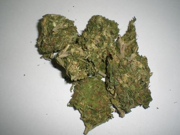

In [ ]:
Image.open("/content/images_by_id/1154.jpg")

In [ ]:
test_set.loc[test_set['image_id']==8121]

,index,category,image_id,image_values
106,185993,Cannabis,8121.0,"[[[250, 250, 250], [250, 250, 250], [250, 250,..."


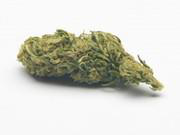

In [ ]:
Image.open("/content/images_by_id/8121.jpg")

In [ ]:
test_set.loc[test_set['image_id']==23647.0]

,index,category,image_id,image_values
4,112978,Weed,23647.0,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."


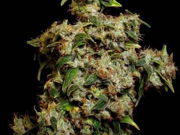

In [ ]:
Image.open("/content/images_by_id/23647.jpg")

In [ ]:
test_set.loc[test_set['image_id']==37684.0]

,index,category,image_id,image_values
28,117379,Weed,37684.0,"[[[75, 88, 42], [57, 69, 21], [84, 94, 44], [7..."


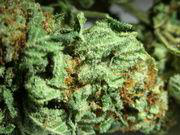

In [ ]:
Image.open("/content/images_by_id/37684.jpg")

In [ ]:
test_set.iloc[154,:]

index                                                       52182
category                                                 Cannabis
image_id                                                      602
image_values    [[[191, 179, 167], [200, 190, 178], [205, 195,...
Name: 154, dtype: object

In [ ]:
print("Predicted :- ",output[preds_knn[154]])

Predicted :-  Weed


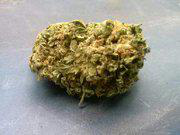

In [ ]:
Image.open("/content/images_by_id/602.jpg")